The quality of OCR, or Optical Character Recognition, for handwritten documents versus typewritten documents differ vastly; OCR for handwritten documents is notably inferior compared to that of typewritten documents. This in turn then creates biases and silences in datasets where handwritten documents are less accessible and are thus less utilized by researchers due to their lack of quality OCR.

In this notebook, I analyze 5 different OCR tools to measure their performance for different types of documents, with the goal of finding one that can be ultimately be used to unlock more handwritten data within the UCSF Archives and Special Collections.

You can view the dataset I'm using [here](https://drive.google.com/file/d/1ChC4ntZbo3t4IBmuNYtA8LoqPoY84LNN/view?usp=sharing). You can view the keyword results [here](https://drive.google.com/drive/folders/1-38TQuXrnxMwIc9tRg3Z1gbk-UB_7c_r?usp=drive_link).

#Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd "/content/drive/MyDrive/UCSF_ASC"

/content/drive/MyDrive/UCSF_ASC


In [ ]:
import os
import pandas as pd

csv_path = 'asc_documents.csv'
df = pd.read_csv(csv_path)
prefix = "OCR_dataset/"
base = "/content/drive/MyDrive/UCSF_ASC/"

template_df = pd.DataFrame(columns=["path", "format", "ocr"])
template_df["path"] = prefix + df['source_file'].astype(str) + '/' + df['page_num'].astype(str) + ".pdf"
template_df["format"] = df["format"].copy()
template_df.head()

,path,format,ocr
0,OCR_dataset/ucsf_mss2015-01_011_061/40.pdf,handwritten,NaN
1,OCR_dataset/ucsf_mss2015-01_011_061/9.pdf,handwritten,NaN
2,OCR_dataset/mss94-60_8_46_peopleofcolorcaucus1...,handwritten,NaN
3,OCR_dataset/mss94-60_8_46_peopleofcolorcaucus1...,handwritten,NaN
4,OCR_dataset/mss94-60_22_15/28.pdf,handwritten,NaN


In [ ]:
#dict to hold all the final scores
all_scores = {'Tesseract':[], 'Vertex AI':[], 'Textract':[], 'Versa':[] }

##Set up for evaluating quality of OCR

In [ ]:
!sudo pip3 install git+https://github.com/casics/nostril.git

  Cloning https://github.com/casics/nostril.git to /tmp/pip-req-build-gf6sihy2
  Running command git clone --filter=blob:none --quiet https://github.com/casics/nostril.git /tmp/pip-req-build-gf6sihy2
  Resolved https://github.com/casics/nostril.git to commit fbc0c91249283a9fbc9036206391ce1138826fd3
  Preparing metadata (setup.py) ... done
  Created wheel for nostril: filename=nostril-1.2.0-py3-none-any.whl size=5765786 sha256=ef97c00ea027750215c852beaa1ef9635ccfe34dd604fb9b2d879cdd129f2ac6
  Stored in directory: /tmp/pip-ephem-wheel-cache-xt549r0d/wheels/de/3e/43/5b766704a7dbffce33fcbd15a63a9919cb9cc743e04780b9d6
Successfully built nostril


In [ ]:
#produces ratio of nonsense text to total text, so closer to 1 = worse
#cite gordon's notebook
from nostril import nonsense

def nostril_eval(ocr):
  s = 0
  t = 0
  for line in ocr.split("\n"):
    try:
      if nonsense(line):
        s += 1
    except:
      s += 1
    t += 1

  return s / t

In [ ]:
import numpy as np

def total_eval(df):
  handwritten_score = 0
  handwritten_docs = 0
  typed_score = 0
  typed_docs = 0
  mixed_score = 0
  mixed_docs = 0

  for index, row in df.iterrows():
    if row['format'] == 'handwritten':
      curr_score = nostril_eval(df.loc[index, 'ocr'])
      handwritten_score += curr_score
      handwritten_docs += 1
    elif row['format'] == 'typed':
      curr_score = nostril_eval(df.loc[index, 'ocr'])
      typed_score += curr_score
      typed_docs += 1
    else:
      curr_score = nostril_eval(df.loc[index, 'ocr'])
      mixed_score += curr_score
      mixed_docs += 1
  final_scores = np.array([handwritten_score, typed_score, mixed_score])/np.array([handwritten_docs, typed_docs, mixed_docs])
  return {"Handwritten": final_scores[0], "Typed": final_scores[1], "Mixed": final_scores[2]}

# Tesseract

##Generating OCR for each document

In [ ]:
!sudo apt-get install poppler-utils
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install tempfile
!pip install pdf2image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.4 [186 kB]
Fetched 186 kB in 1s (129 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 123589 

In [ ]:
import pytesseract
from PIL import Image
from pdf2image import convert_from_path

In [ ]:
#a dataframe to contain the id, path, type, and OCR of each document
tesseract_df = template_df.copy()
tesseract_df.head()

,path,format,ocr
0,OCR_dataset/ucsf_mss2015-01_011_061/40.pdf,handwritten,NaN
1,OCR_dataset/ucsf_mss2015-01_011_061/9.pdf,handwritten,NaN
2,OCR_dataset/mss94-60_8_46_peopleofcolorcaucus1...,handwritten,NaN
3,OCR_dataset/mss94-60_8_46_peopleofcolorcaucus1...,handwritten,NaN
4,OCR_dataset/mss94-60_22_15/28.pdf,handwritten,NaN


In [ ]:
def ocr_pdf(pdf_path):
    images = convert_from_path(pdf_path)
    text = ""
    for image in images:
        text += pytesseract.image_to_string(image, lang='eng')
    return str(text)

In [ ]:
%%time
for idx, row in tesseract_df.iterrows():
    pdf_path = base + row['path']
    ocr_text = ocr_pdf(pdf_path)
    tesseract_df.at[idx, 'ocr'] = ocr_text

CPU times: user 1.59 s, sys: 1.71 s, total: 3.3 s
Wall time: 3min 20s


CAUFORNIAS WAR ON AIDS 19897-1991

_

Estimated Service Uti ligation Chart for Hu. infection stages Ti+!

   
   
    
   

Resides tial
Hospice
Facility

  
 

Sore
Outpatient Care

    
 
    

Skilled .
Norsing Facility

  

0 Ys
Home ttealth Care

PATIENT CATESCUES USING MORE THAN ONE SERVICE ComPonenT.
Casemanagement Services for 100° of- patient Popalation .
Emotional Support Services for. 20/0 of petient Populahon.
ss S/o Baberwittent Mises.

1S*%o Attendant Care.
12 %/e Home Support Services.
\ /s Critical Mental Henith Care in the home.

B pot Shared and Referred Housing ‘3
S% Shanti - Eype Roosing -

OA S/t/e>



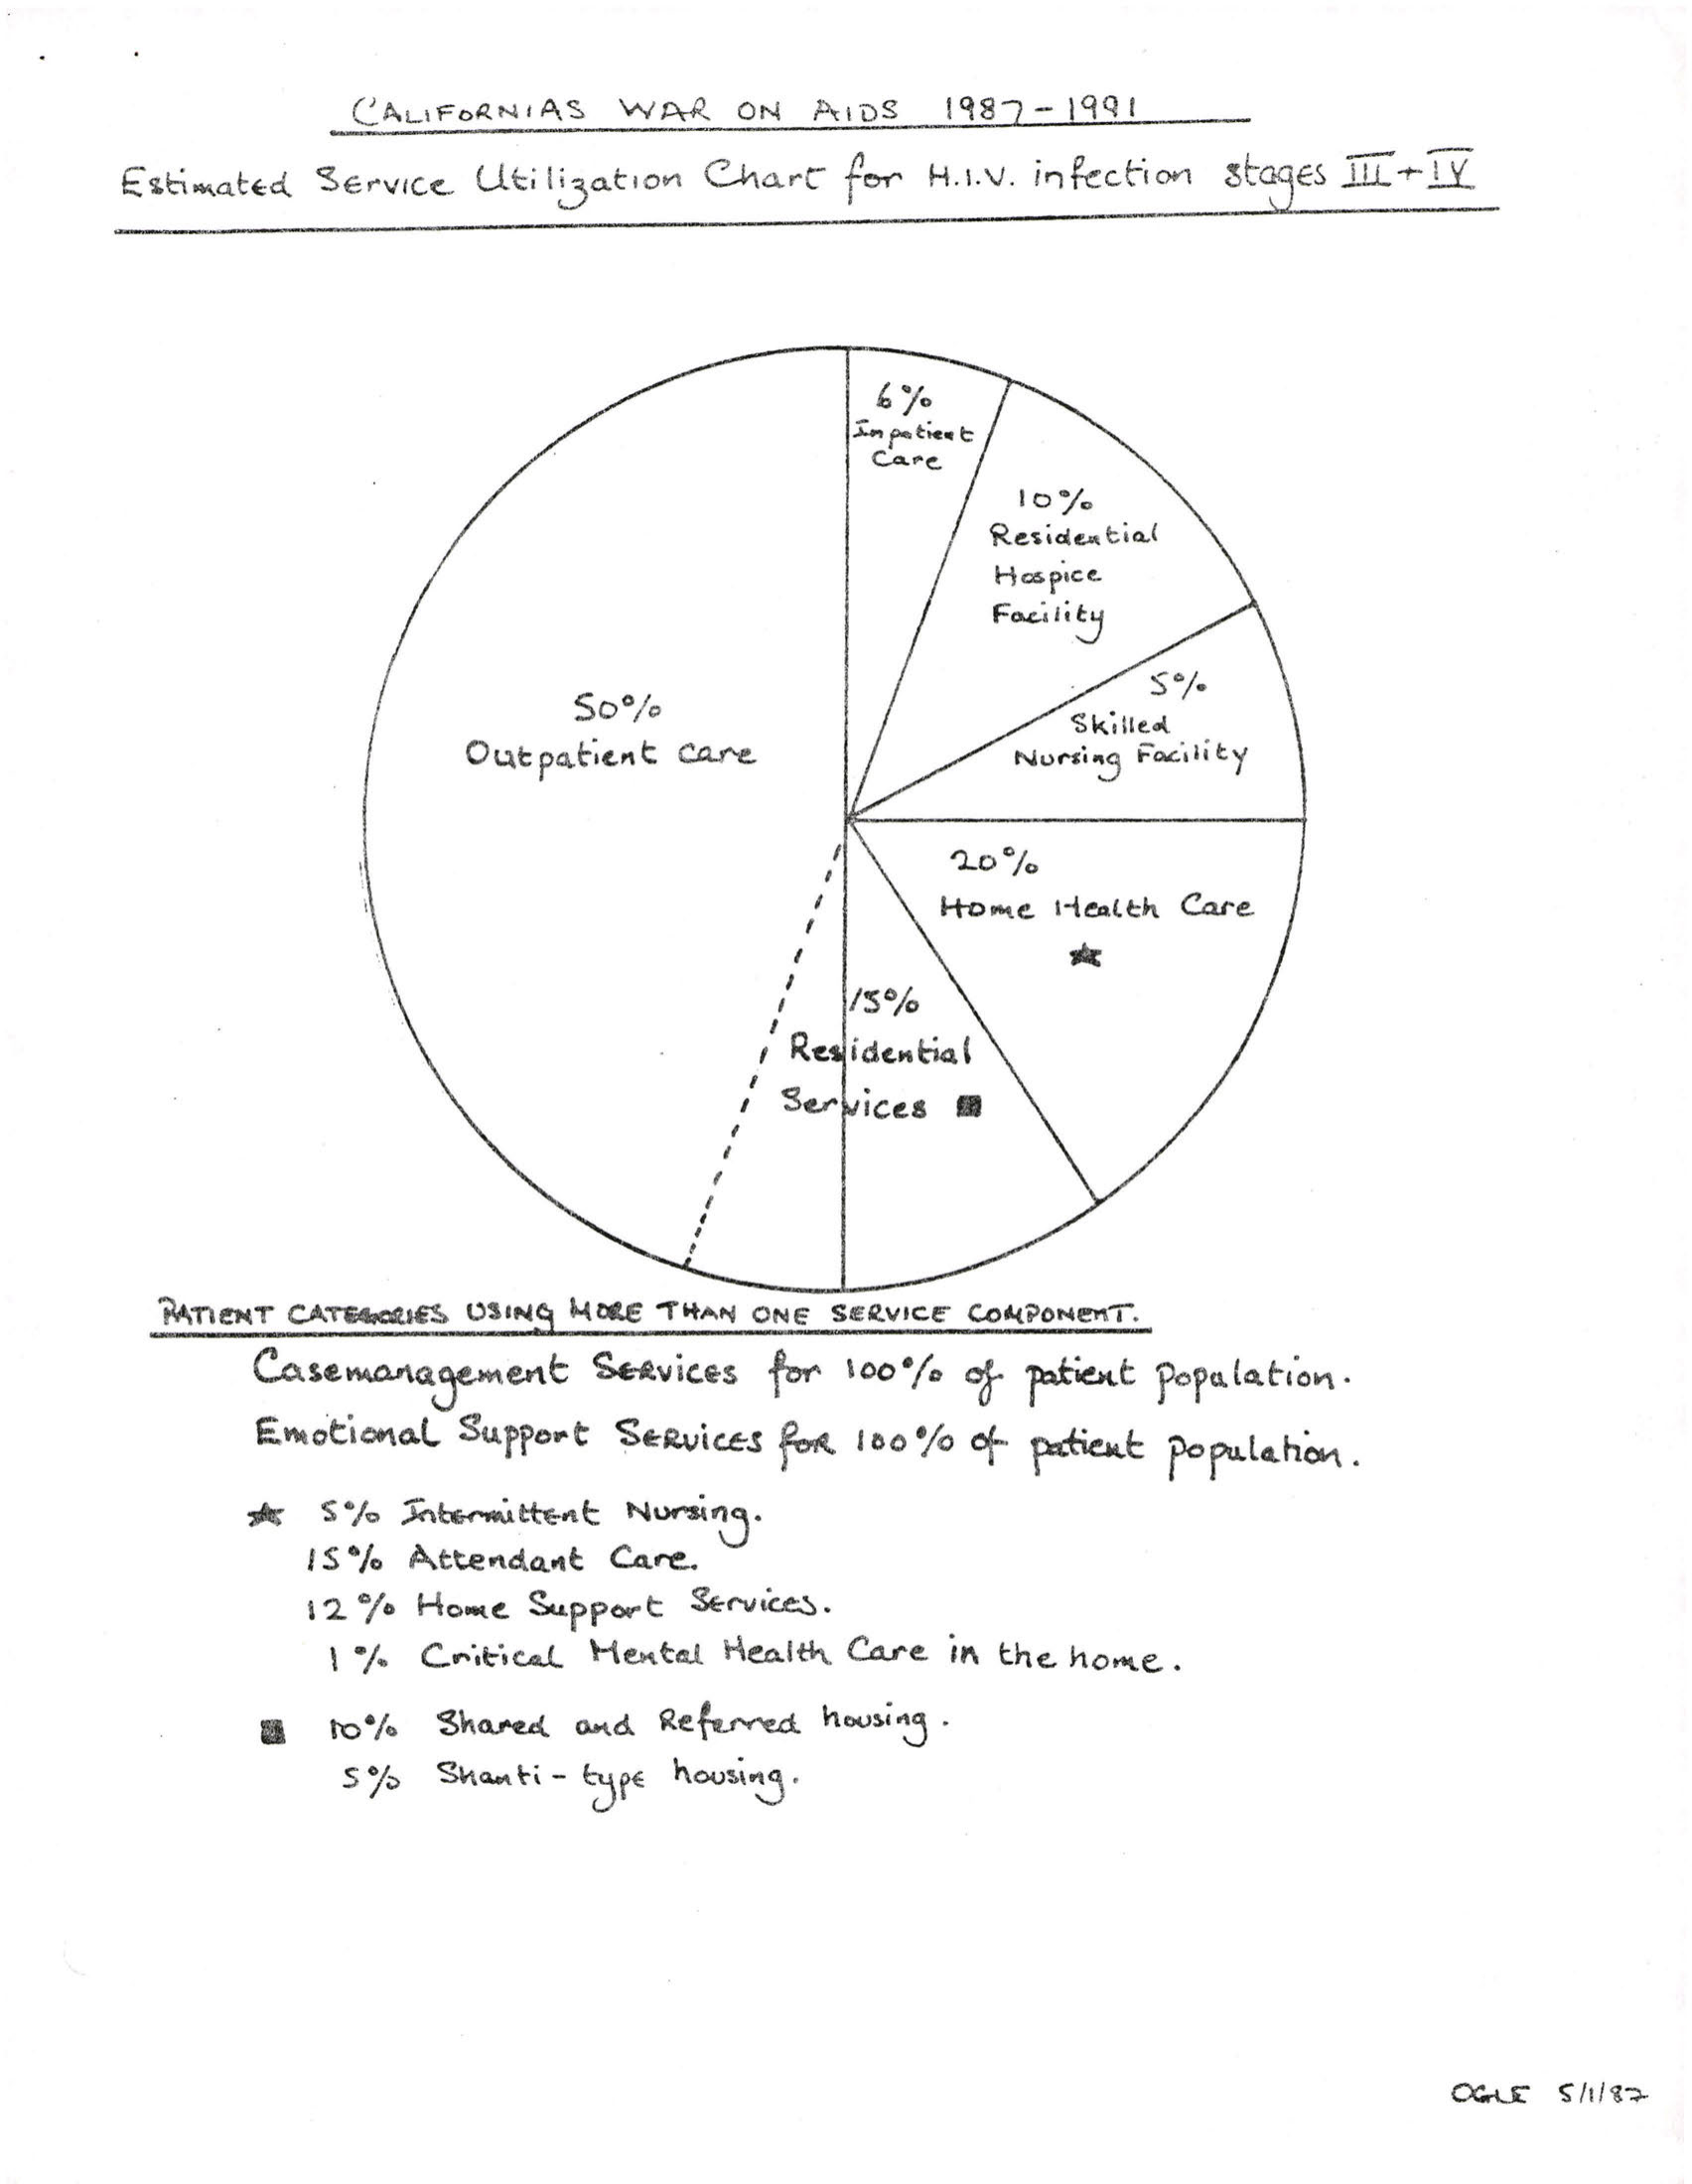

In [ ]:
print(tesseract_df.loc[0, "ocr"])
image = convert_from_path(tesseract_df.loc[0, "path"], jpegopt=True)
image[0]

##Evaluating quality of OCR

In [ ]:
tesseract_scores = total_eval(tesseract_df)
tesseract_scores

{'Handwritten': 0.6373027243103667,
 'Typed': 0.31950197880654874,
 'Mixed': 0.594694320090403}

In [ ]:
all_scores['Tesseract'] = tesseract_scores
print(all_scores)

{'Tesseract': {'Handwritten': 0.6373027243103667, 'Typed': 0.31950197880654874, 'Mixed': 0.594694320090403}, 'Vertex AI': [], 'Textract': [], 'Versa': []}


In [ ]:
#save the result to a csv
tesseract_csv_path = '/content/drive/MyDrive/UCSF_ASC/Results/tesseract_results.csv'

# Save the DataFrame to a CSV file
tesseract_df.to_csv(tesseract_csv_path, index=False)

#Vertex AI

##Generating OCR for each document

In [ ]:
!pip3 install --upgrade google-cloud-documentai
!pip3 install --upgrade google-cloud-storage
!pip3 install --upgrade google-cloud-documentai-toolbox

  Using cached google_cloud_storage-2.17.0-py2.py3-none-any.whl (126 kB)
  Attempting uninstall: google-cloud-storage
    Found existing installation: google-cloud-storage 2.8.0
    Uninstalling google-cloud-storage-2.8.0:
      Successfully uninstalled google-cloud-storage-2.8.0


  Using cached google_cloud_documentai_toolbox-0.13.5a0-py2.py3-none-any.whl (42 kB)
  Using cached pyarrow-15.0.2-cp310-cp310-manylinux_2_28_x86_64.whl (38.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.4/466.4 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 24.1 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=34dfdfddce6e2e617f75f88e9cf0d667f47030473f9164672afaaae37fab5b9d
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempt

In [ ]:
vertex_df = template_df.copy()
vertex_df.head()

,path,format,ocr
0,OCR_dataset/ucsf_mss2015-01_011_061/40.pdf,handwritten,NaN
1,OCR_dataset/ucsf_mss2015-01_011_061/9.pdf,handwritten,NaN
2,OCR_dataset/mss94-60_8_46_peopleofcolorcaucus1...,handwritten,NaN
3,OCR_dataset/mss94-60_8_46_peopleofcolorcaucus1...,handwritten,NaN
4,OCR_dataset/mss94-60_22_15/28.pdf,handwritten,NaN


In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "path/to/credentials"

NameError: name 'os' is not defined

In [ ]:
#Code interpreted from here: https://codelabs.developers.google.com/codelabs/docai-ocr-python#7

%%time

from google.api_core.client_options import ClientOptions
from google.cloud import documentai

PROJECT_ID = 'your_id'
LOCATION = 'us'  # Format is 'us' or 'eu'
PROCESSOR_ID = 'your_id'  # Create processor in Cloud Console

for index, row in vertex_df.iterrows():
  # The local file in your current working directory
  FILE_PATH = row['path']
  # Refer to https://cloud.google.com/document-ai/docs/file-types
  # for supported file types
  MIME_TYPE = "application/pdf"

  # Instantiates a client
  docai_client = documentai.DocumentProcessorServiceClient(
      client_options=ClientOptions(api_endpoint=f"{LOCATION}-documentai.googleapis.com")
  )

  # The full resource name of the processor, e.g.:
  # projects/project-id/locations/location/processor/processor-id
  # You must create new processors in the Cloud Console first
  RESOURCE_NAME = docai_client.processor_path(PROJECT_ID, LOCATION, PROCESSOR_ID)

  # Read the file into memory
  with open(FILE_PATH, "rb") as image:
      image_content = image.read()

  # Load Binary Data into Document AI RawDocument Object
  raw_document = documentai.RawDocument(content=image_content, mime_type=MIME_TYPE)

  # Configure the process request
  request = documentai.ProcessRequest(name=RESOURCE_NAME, raw_document=raw_document)

  # Use the Document AI client to process the sample form
  result = docai_client.process_document(request=request)

  document_object = result.document
  # print("Document processing complete.")
  # print(f"Text: {document_object.text}")
  vertex_df.at[index, 'ocr'] = document_object.text

CPU times: user 2.9 s, sys: 221 ms, total: 3.12 s
Wall time: 1min 10s


In [ ]:
# print(vertex_df.loc[0, "ocr"])
# image = convert_from_path(vertex_df.loc[0, "path"], jpegopt=True)
# image[0]

In [ ]:
# #save the result to a csv
# vertex_csv_path = '/content/drive/MyDrive/UCSF_ASC/vertex_results.csv'

# # Save the DataFrame to a CSV file
# vertex_df.to_csv(vertex_csv_path, index=False)

##Evaluating quality of OCR

In [ ]:
vertex_scores = total_eval(vertex_df)
vertex_scores

{'Handwritten': 0.36308855561565734,
 'Typed': 0.07735532079436237,
 'Mixed': 0.3045405488995745}

In [ ]:
all_scores['Vertex AI'] = vertex_scores
print(all_scores)

{'Tesseract': {'Handwritten': 0.6373027243103667, 'Typed': 0.31950197880654874, 'Mixed': 0.594694320090403}, 'Vertex AI': {'Handwritten': 0.36308855561565734, 'Typed': 0.07735532079436237, 'Mixed': 0.3045405488995745}, 'Textract': [], 'Versa': []}


#Textract

In [ ]:
!pip install aws configure
# !pip install awscli
# !aws configure
!pip install boto3

ERROR: Operation cancelled by user


In [ ]:
#configuring my aws credentials, only needs to be run once since it's essentially saving your credentials on google drive

# text = '''
# [default]
# aws_access_key_id = XXXXXXXXXXXXXXXXXXXXXXXX
# aws_secret_access_key = XXXXXXXXXXXXXXXXXXXXXXXXXX
# region = us-west-2
# output_format = text
# '''
# path = "/content/drive/MyDrive/UCSF_ASC/awscli.ini"
# with open(path, 'w') as f:
#    f.write(text)
# !cat /content/drive/MyDrive/UCSF_ASC/awscli.ini

In [ ]:
os.environ["AWS_CONFIG_FILE"] = "/content/drive/MyDrive/UCSF_ASC/awscli.ini"

##Generating OCR for each document

In [ ]:
textract_df = template_df.copy()
textract_df.head()

,path,format,ocr
0,OCR_dataset/ucsf_mss2015-01_011_061/40.pdf,handwritten,NaN
1,OCR_dataset/ucsf_mss2015-01_011_061/9.pdf,handwritten,NaN
2,OCR_dataset/mss94-60_8_46_peopleofcolorcaucus1...,handwritten,NaN
3,OCR_dataset/mss94-60_8_46_peopleofcolorcaucus1...,handwritten,NaN
4,OCR_dataset/mss94-60_22_15/28.pdf,handwritten,NaN


In [ ]:
%%time
import boto3

client = boto3.client('textract')

for index, row in textract_df.iterrows():
  with open(row['path'], 'rb') as document:
    img = bytearray(document.read())

  response = client.detect_document_text(
      Document={'Bytes': img}
  )

  curr_ocr = ''

  for item in response["Blocks"]:
      if item["BlockType"] == "LINE":
          curr_ocr += (item["Text"] + '\n')

  row['ocr'] = curr_ocr

CPU times: user 1.9 s, sys: 195 ms, total: 2.1 s
Wall time: 1min 27s


In [ ]:
# #save the result to a csv
# textract_csv_path = '/content/drive/MyDrive/UCSF_ASC/textract_results.csv'

# # Save the DataFrame to a CSV file
# textract_df.to_csv(textract_csv_path, index=False)

##Evaluating quality of OCR

In [ ]:
textract_scores = total_eval(textract_df)
textract_scores

{'Handwritten': 0.2988230356245062,
 'Typed': 0.0767503204048502,
 'Mixed': 0.2643127764124537}

In [ ]:
all_scores['Textract'] = textract_scores
print(all_scores)

{'Tesseract': {'Handwritten': 0.6373027243103667, 'Typed': 0.31950197880654874, 'Mixed': 0.594694320090403}, 'Vertex AI': {'Handwritten': 0.36308855561565734, 'Typed': 0.07735532079436237, 'Mixed': 0.3045405488995745}, 'Textract': {'Handwritten': 0.2988230356245062, 'Typed': 0.0767503204048502, 'Mixed': 0.2643127764124537}, 'Versa': []}
